In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas.plotting import scatter_matrix
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.special import expit
from sklearn.utils import shuffle
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import log_loss


In [2]:
water_data = pd.read_csv('water_potability.csv').dropna().sample(frac = 1)
pipe = Pipeline([('rscaler', RobustScaler()), ('mscaler', MinMaxScaler())])
water_data_tr = pipe.fit_transform(water_data)
col_names = list(water_data)
features = col_names[0:len(col_names)-1]

water_data_df = pd.DataFrame(water_data_tr, columns = col_names)
y = water_data_df["Potability"]
X = water_data_df.drop(["Potability"], axis = 1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
X_test = X_test.to_numpy()
X_train = X_train.to_numpy()
y_test = y_test.to_numpy()
y_train = y_train.to_numpy()


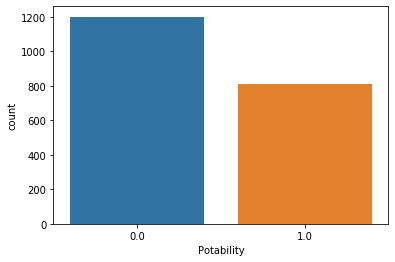

In [3]:
sns.countplot(x=water_data_df['Potability'])


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6b2c0c99d0>,
      dtype=object)

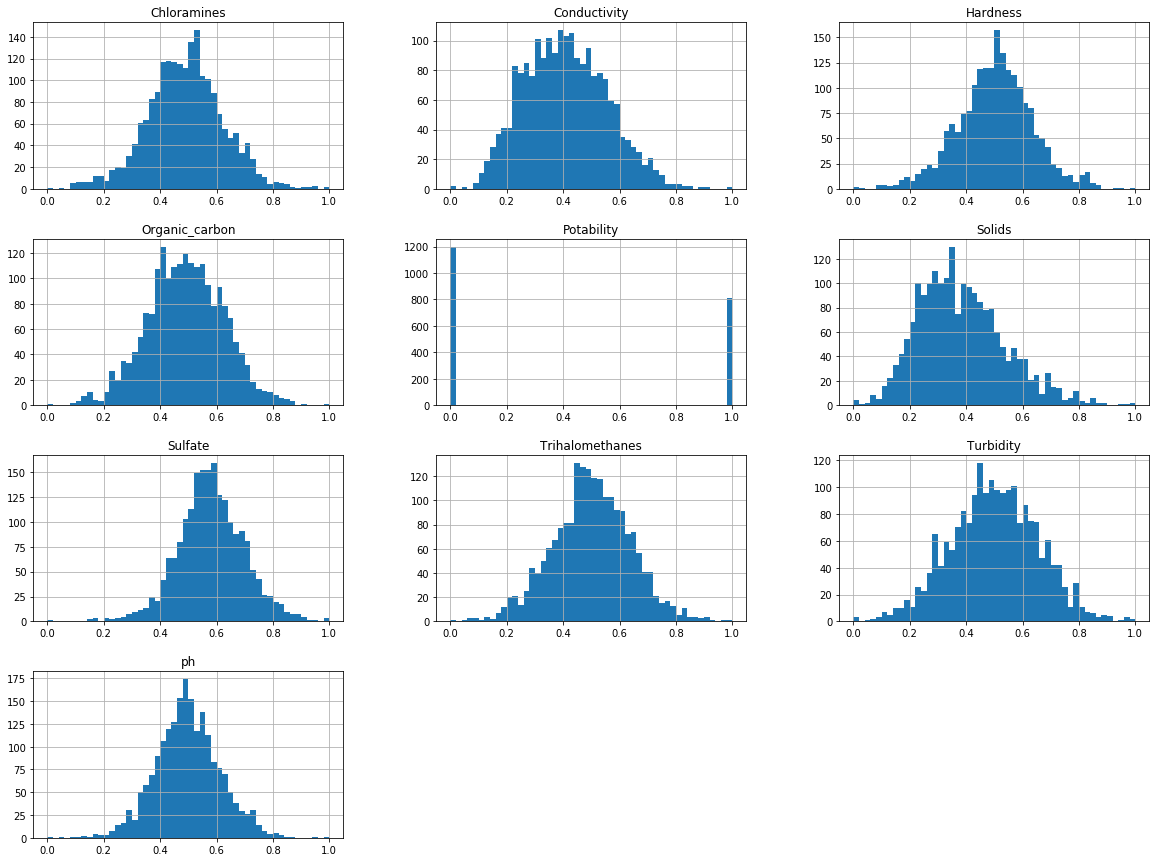

In [4]:
water_data_df.hist(bins=50, figsize=(20,15))

In [5]:
correlations = water_data_df.corr()

In [6]:
correlations["Potability"].sort_values(ascending = False)

Potability         1.000000
Solids             0.040674
Turbidity          0.022682
Chloramines        0.020784
ph                 0.014530
Trihalomethanes    0.009244
Hardness          -0.001505
Sulfate           -0.015303
Conductivity      -0.015496
Organic_carbon    -0.015567
Name: Potability, dtype: float64

0       0.481641
1       0.319424
2       0.582414
3       0.556329
4       0.830854
          ...   
2006    0.489317
2007    0.384299
2008    0.572196
2009    0.543941
2010    0.781478
Name: Sulfate, Length: 2011, dtype: float64

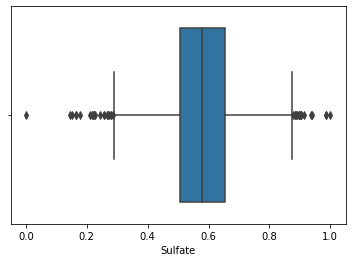

In [7]:
sns.boxplot(x = water_data_df["Sulfate"])
water_data_df["Sulfate"]

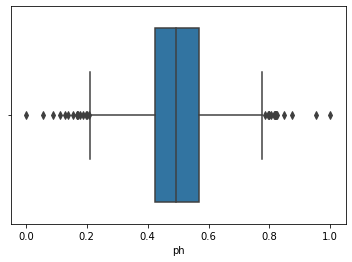

In [8]:
sns.boxplot(x = water_data_df["ph"])


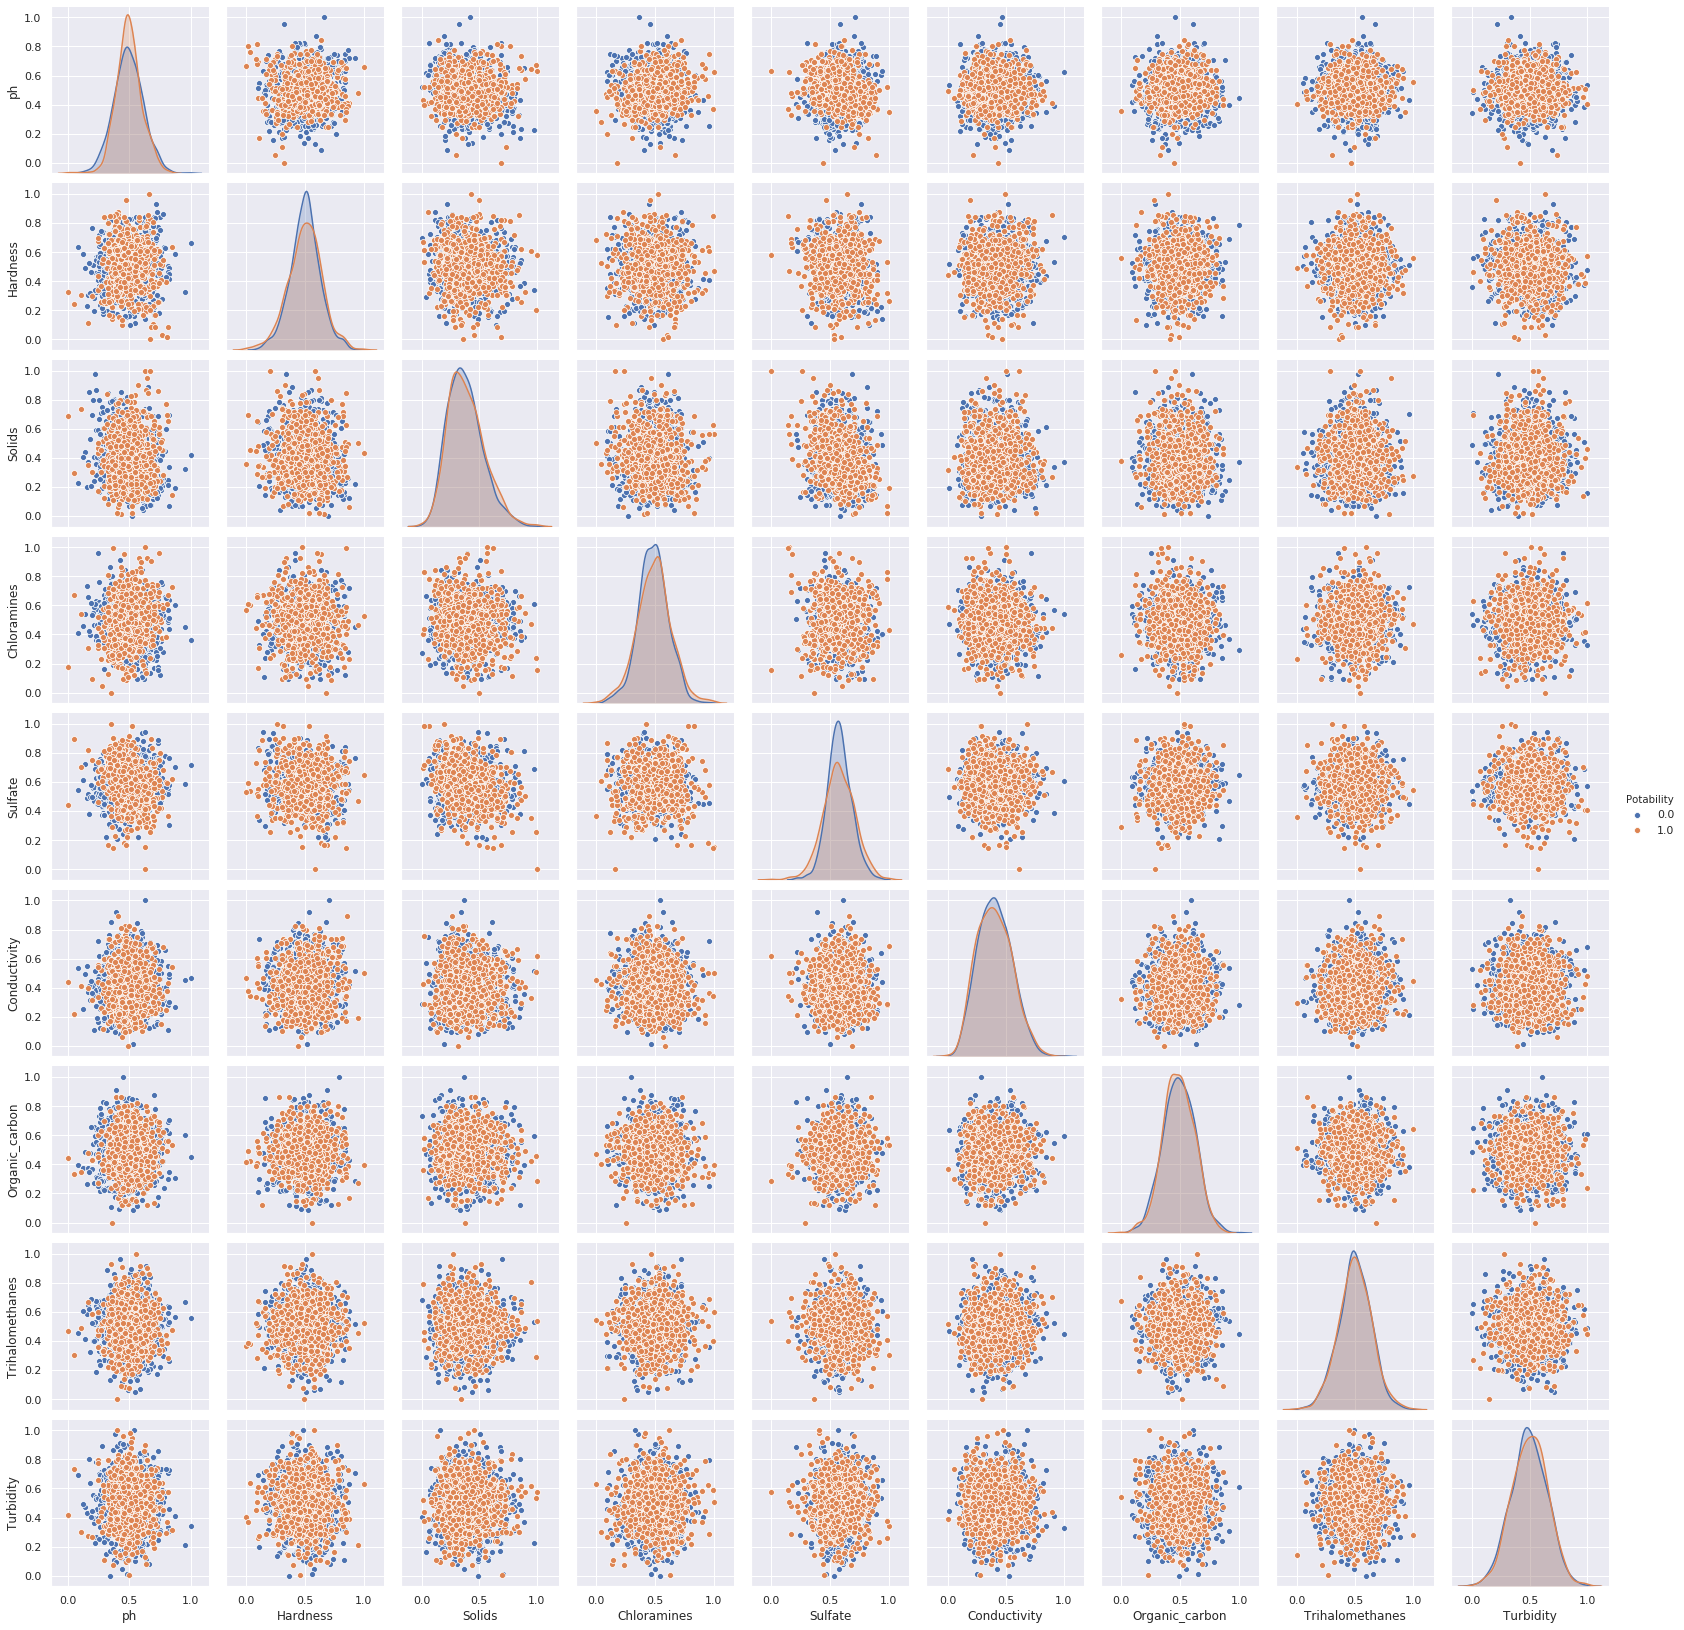

In [9]:
sns.set()
sns.pairplot(water_data_df,hue='Potability')
sns.set_style('darkgrid')

In [10]:
Q1 = water_data_df.quantile(0.25)
Q2 = water_data_df.quantile(0.75)


In [11]:
def log_loss_func(y,p):
    one = np.ones(y.shape[0])
    return np.sum(-1*(y*np.log(p) + (one-y)*np.log(one - p)))/y.shape[0]
    

In [12]:
def sig(x):
    return expit(x)

In [13]:
def sig_der(x):
    return sig(x)*(np.ones(x.shape[0])-sig(x))

In [14]:
def shuff_data(df):
    water_data_df = df.sample(frac = 1)
    y = water_data_df["Potability"]
    X = water_data_df.drop(["Potability"], axis = 1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
    return X_train.to_numpy(), y_train.to_numpy()

    
    

In [17]:
def logistic_regression(num_iters, df, eps, lambda_):
    w = np.ones(X_train[0].shape).astype(np.float64)

    for _ in range(num_iters):
        X, y = shuff_data(df)
        for x_i, y_i in zip(X, y):
            w = w + eps*(y_i-sig(w.dot(x_i))*x_i - 2*lambda_*w)
    return w

In [46]:
w = logistic_regression(1000, water_data_df, 0.2, 0.9)


In [47]:
y_pred = sig(X_test.dot(w))
    

In [48]:
log_loss_func(y_test, y_pred)
#len(np.where(y_test-y_pred == 0)[0])/len(y_test)

0.7783743349793769

In [49]:
def kernel_logistic_regression(df, num_iters, alpha, K):
    a = np.ones(K[1].shape[0])
    
    for _ in range(num_iters):
        X, y = shuff_data(df)
        K = X.dot(X.T)
        for y_i, k in zip(y, K):
            a = a + alpha*(y_i-sig(k.dot(a)))
    return a
        

In [50]:
a = kernel_logistic_regression(water_data_df, 1000, 0.009, X_train.dot(X_train.T))

In [51]:
def classify(a):
    K = X_train.dot(X_test.T)
    return sig(a.dot(K))
  
    

In [52]:
y_pred_ker = classify(a)


In [53]:
log_loss_func(y_test, y_pred_ker)

5.4960857987498954

In [54]:
def glorot_weights(f_in,f_out):
    avg = (f_in+f_out)/2
    return np.random.normal(0, 1/(np.sqrt(avg)), size=(f_in, f_out))


In [58]:
def NNClassifier(X, y, iters, alpha):
    w_1 = glorot_weights(X.shape[0], X.shape[1])
    a = sig(w_1.dot(X.T))
    w_2 = glorot_weights(1, a.shape[0])
    p = sig(w_2.dot(a)).reshape(-1)
    one = np.ones(y.shape[0])

    losses = []
    for _ in range(iters):

        w_1 += alpha/y.shape[0]*(np.sum((y/p + one-y/one-p)))*(sig_der(w_2.dot(a)).dot(w_2.reshape(-1))*(sig_der(w_1.dot(X.T)).dot(X)))
        w_2 += alpha/y.shape[0]*(np.sum((y/p + one-y/one-p)))*sig_der(w_2.dot(a))
        a = sig(w_1.dot(X.T))
        p = sig(w_2.dot(a)).reshape(-1)
        losses.append(log_loss_func(y, p))
    return p
    
    
    

In [61]:
probs = NNClassifier(X, y, 1000, 0.000001)
probs

array([0.48730924, 0.48822955, 0.48796082, ..., 0.48912488, 0.48672509,
       0.48595117])

In [62]:
log_loss_func(y,probs)


0.688375630192445